### Measuring the focus offsets for the MMIRS wavefront sensors

This notebook works through data taken the night of 2019/01/15 to calibrate the focus offsets between the MMIRS instrument and its two off-axis Shack-Hartmann wavefront sensors. After converging with one of the off-axis WFS's, a pair of images were taken with MMIRS in imaging mode after applying focus changes of +500 and -500 microns at M2. These out-of-focus images can then be analyzed using a curvature wavefront sensing algorithm. We use the system developed for the LSST (https://arxiv.org/abs/1506.04839) to perform the analysis. It is fully generalized and can be configured to work with any telescope/instrument. 

In [1]:
# Set up imports, data directory, and configure path to find 
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

%load_ext autoreload
%autoreload 2

sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/mmirs/2019.0115/

from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

/Users/tim/MMT/mmirs/2019.0115


In [2]:
# converged with camera 1 to a focus value of 9746.73
# donuts were becoming saturated by even the midpoint of the ramp, but the 3rd readout is fine
cam1_extra_whole = fits.open("tyc3778-00232-1.5988.fits")[3].data  # focus 10246.0
cam1_intra_whole = fits.open("tyc3778-00232-1.5989.fits")[3].data  # focus 9245.18
cam1_extra = cam1_extra_whole[977-40:977+40, 994-40:994+40] - np.median(cam1_extra_whole)
cam1_intra = cam1_intra_whole[977-40:977+40, 993-40:993+40] - np.median(cam1_intra_whole)

# converved with camera 2 to a focus value of 9695.91
# no saturation even at the end of the ramp
cam2_extra_whole = fits.open("tyc3778-00232-1.5990.fits")[11].data  # focus 10195.56
cam2_intra_whole = fits.open("tyc3778-00232-1.5991.fits")[11].data  # focus 9194.82
cam2_extra = cam2_extra_whole[981-40:981+40, 992-40:992+40] - np.median(cam2_extra_whole)
cam2_intra = cam2_intra_whole[981-40:981+40, 994-40:994+40] - np.median(cam2_intra_whole)

# write out cutout images for convenience later
fits.writeto("cam1_intra.fits", cam1_intra, overwrite=True)
fits.writeto("cam1_extra.fits", cam1_extra, overwrite=True)
fits.writeto("cam2_intra.fits", cam2_intra, overwrite=True)
fits.writeto("cam2_extra.fits", cam2_extra, overwrite=True)

<IPython.core.display.Javascript object>


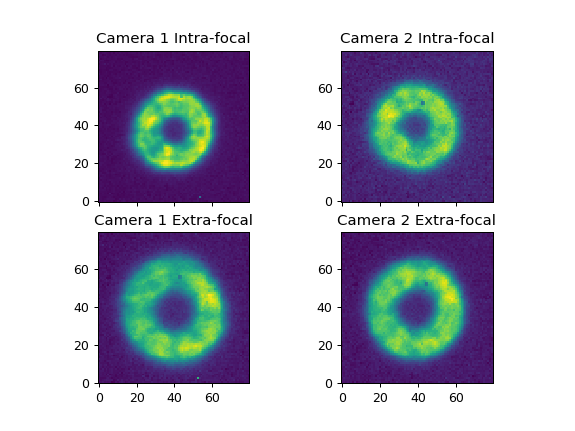

In [3]:
fig, axs = plt.subplots(2, 2, sharex=True)
axs[0, 0].imshow(cam1_intra, origin='lower')
axs[0, 0].set_title("Camera 1 Intra-focal")
axs[1, 0].imshow(cam1_extra, origin='lower')
axs[1, 0].set_title("Camera 1 Extra-focal")
axs[0, 1].imshow(cam2_intra, origin='lower')
axs[0, 1].set_title("Camera 2 Intra-focal")
axs[1, 1].imshow(cam2_extra, origin='lower')
axs[1, 1].set_title("Camera 2 Extra-focal")
plt.show()

In [5]:
# set up and configure the Instrument instance for doing the CWFS calculation
mmirs = Instrument('mmirs', cam1_intra.shape[0])   # images must be square and same size

mmirs.obscuration = 0.26                           # relative size of the central obscuration
mmirs.apertureDiameter = 6.5024                    # MMT diameter in meters
mmirs.pixelSize = 18e-6                            # MMIRS has 18 micron pixels
mmirs.focalLength = mmirs.apertureDiameter * 2.85  # effective focal length for MMIRS's f/2.85 imaging
mmirs.offset = 2.85**2 / 1.25**2 * .5e-3           # MMIRS images at f/2.85 and we used +/- 500 um focus offsets

algo = Algorithm('exp', mmirs, 3)

In [6]:
fieldXY = [0., 0.]  # assume we're on axis. haven't implemented MMT off-axis models into LSST CWFS code yet.
I1_cam1 = Image(readFile("cam1_intra.fits"), fieldXY, Image.INTRA)
I2_cam1 = Image(readFile("cam1_extra.fits"), fieldXY, Image.EXTRA)
algo.runIt(mmirs, I1_cam1, I2_cam1, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   40.25,   38.23)

imageCoCenter: (x1,y1)=(   40.45,   38.71)

itr = 0, z4-z22
[1109. -111.   31.  -36.   99.    7.  -35.  -17.  -19.  -18.  -28.    3.
    4.   -6.    9.   16.   14.   -5.  -64.]
itr = 1, z4-z22
[1261. -141.    6.  -48.  122.   24.  -27.  -21.  -20.  -19.  -28.   -3.
    6.    3.    9.   15.   11.   -0.  -26.]
itr = 2, z4-z22
[1363. -159.   -8.  -28.  110.   26.  -37.  -17.  -18.  -16.  -20.   -2.
    5.   -7.   11.   16.   10.   -5.  -12.]
itr = 3, z4-z22
[1412. -180.  -18.  -36.  117.   25.  -38.  -14.  -16.  -18.  -18.   -2.
   -5.   -3.   11.   17.    9.   -6.   -4.]
itr = 4, z4-z22
[ 1.423e+03 -1.880e+02 -3.000e+01 -3.600e+01  1.240e+02  3.200e+01
 -3.300e+01 -1.100e+01 -1.700e+01 -2.100e+01 -1.900e+01 -3.000e+00
 -0.000e+00 -1.000e+00  1.000e+01  1.700e+01  8.000e+00 -4.000e+00
  1.000e+00]
itr = 5, z4-z22
[ 1.444e+03 -2.190e+02 -3.600e+01 -3.500e+01  1.070e+02  3.000e+01
 -4.200e+01 -1.100e+01 -1.900e+01 -2.30

In [7]:
cam1_zv = ZernikeVector()
cam1_zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
cam1_zv.denormalize()
cam1_zv

Fringe Coefficients
 Z04:                  2560 nm 	 Defocus (2, 0)
 Z05:                -651.1 nm 	 Primary Astig at 45° (2, -2)
 Z06:                -192.7 nm 	 Primary Astig at 0° (2, 2)
 Z07:                -94.02 nm 	 Primary Y Coma (3, -1)
 Z08:                 267.3 nm 	 Primary X Coma (3, 1)
 Z09:                 265.5 nm 	 Y Trefoil (3, -3)
 Z10:                 -64.8 nm 	 X Trefoil (3, 3)
 Z11:                -19.57 nm 	 Primary Spherical (4, 0)
 Z12:                -69.98 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                -98.19 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                -81.45 nm 	 X Tetrafoil (4, 4)
 Z15:                -9.731 nm 	 Y Tetrafoil (4, -4)
 Z16:                 9.091 nm 	 Secondary X Coma (5, 1)
 Z17:                 -9.74 nm 	 Secondary Y Coma (5, -1)
 Z18:                  43.8 nm 	 Secondary X Trefoil (5, 3)
 Z19:                 102.6 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 52.77 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


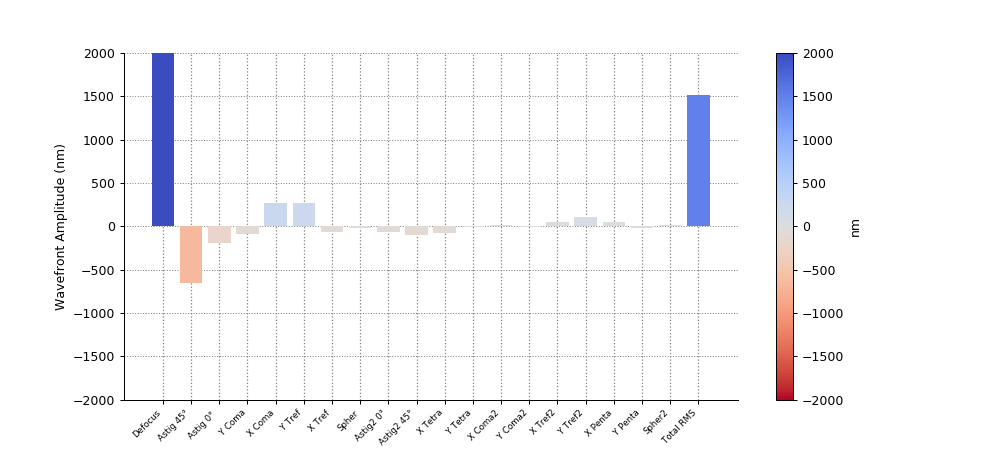

In [8]:
cam1_zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


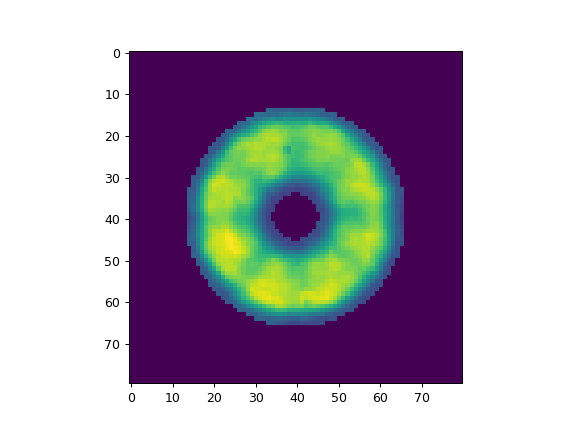

In [9]:
plt.imshow(algo.image)
plt.show()

<IPython.core.display.Javascript object>


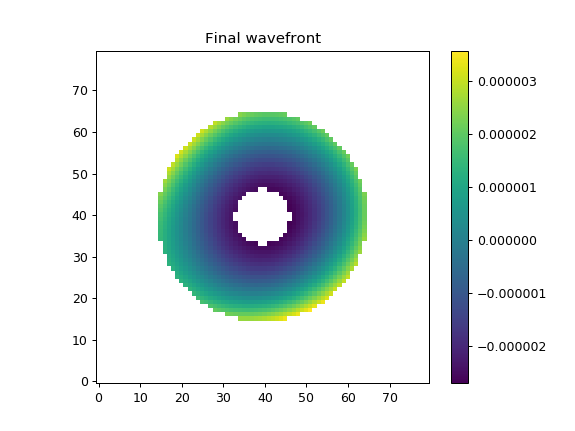

In [10]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

In [11]:
# set up and configure the Instrument instance for doing the CWFS calculation
mmirs = Instrument('mmirs', cam1_intra.shape[0])   # images must be square and same size

mmirs.obscuration = 0.26                           # relative size of the central obscuration
mmirs.apertureDiameter = 6.5024                    # MMT diameter in meters
mmirs.pixelSize = 18e-6                            # MMIRS has 18 micron pixels
mmirs.focalLength = mmirs.apertureDiameter * 2.85  # effective focal length for MMIRS's f/2.85 imaging
mmirs.offset = 2.85**2 / 1.25**2 * .5e-3           # MMIRS images at f/2.85 and we used +/- 500 um focus offsets

algo = Algorithm('exp', mmirs, 3)

In [13]:
fieldXY = [0., 0.]  # assume we're on axis. haven't implemented MMT off-axis models into LSST CWFS code yet.
I1_cam2 = Image(readFile("cam2_intra.fits"), fieldXY, Image.INTRA)
I2_cam2 = Image(readFile("cam2_extra.fits"), fieldXY, Image.EXTRA)
algo.runIt(mmirs, I1_cam2, I2_cam2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   39.60,   39.84)

imageCoCenter: (x1,y1)=(   39.91,   39.11)

itr = 0, z4-z22
[ 671.   69. -159.   38.   34.   12.   -8. -167.   16.   -3.  -34.   -4.
   16.   -6.    7.    7.    1.   -9.   21.]
itr = 1, z4-z22
[ 787.   73. -182.   32.   50.   14.   -5. -154.   16.   -2.  -29.  -10.
    5.   -7.    7.    8.    0.   -8.   36.]
itr = 2, z4-z22
[ 847.   76. -182.   28.   54.   14.   -4. -146.   15.   -2.  -27.  -13.
    1.   -7.    7.    8.   -1.   -8.   44.]
itr = 3, z4-z22
[ 881.   91. -216.   25.   56.   13.   -5. -142.   11.   -0.  -24.  -14.
   -2.   -7.    7.    8.   -1.   -9.   48.]
itr = 4, z4-z22
[ 895.   96. -241.   24.   56.   13.   -3. -141.    8.    0.  -24.  -15.
    3.   -6.    8.    9.   -1.   -9.   50.]
itr = 5, z4-z22
[ 814.   99. -244.   25.   56.   18.   -5. -158.    8.    1.  -25.  -13.
    5.   -3.    8.    9.    0.   -8.   40.]
itr = 6, z4-z22
[ 757.  101. -235.   27.   50.   20.  -10. -167.    8.    1.  -27.  -1